This is the Second part of the notebook "Forecasting_Time_Series_Initial".

We are interested in improving the results we obtained in the predictions, so we'll carry out the necessary research:

I) Test a prediction model **ARIMA**: an autoregressive integrated moving average model. It is a dynamic time series model, that is, future estimates are explained by past data. It should be noted that it is one of the most used models for the prediction of time series.

ARIMA, short for 'Automatic Regressive Integrated Moving Average' is actually a class of models that 'explains' a given time series based on its own past values, i.e. its own lags and lagged forecast errors, so that The equation can be used to predict future values. It is based on the idea that information from past time series can be used to predict future values, for this reason we will use it.
We think we can improve the error in our prediction so we will implement ARIMA.

To do so, we will rely on the following information found on Kaggle and github

https://www.kaggle.com/freespirit08/time-series-for-beginners-with-arima

https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Time%20Series%20Forecastings.ipynb


II) Likewise, as our goal is to improve prediction, another of the options found is **using a neural network**. An artificial neural network (ANN) is a widely used pattern recognition methodology for machine learning. LSTMs are a special type of recurrent networks. The main characteristic of recurrent networks is that information can persist, basically, they can "remember" previous states and use this information to decide what will be next. This feature makes them very suitable for handling time series. While standard recurrent networks can model short-term dependencies (ie close relationships in the time series), LSTMs can learn long-term dependencies, so they could be said to have a longer-term "memory". With this in mind, we collect the following information:

https://www.tensorflow.org/tutorials/structured_data/time_series

https://towardsdatascience.com/3-steps-to-forecast-time-series-lstm-with-tensorflow-keras-ba88c6f05237


The idea would then be to use a simple network or an LSTM for time series. To work with the indicated dataframe, we could try using the time and vehicular flow variables, do a time series split train test and treat it as a model similar to those already tested.

We hope, then, to be able to improve the predictions achievedin the initial notebook


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
#We'll do the same pre-processing 

data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')

dataset = pd.concat([data_2019, data_2018, data_2017])

mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

,fecha,hora_fin,dia,sentido,tipo_vehiculo,cantidad_pasos
80,2019-01-01,2,Martes,Centro,Liviano,537
86,2019-01-01,2,Martes,Centro,Pesado,1
88,2019-01-01,2,Martes,Provincia,Liviano,443
94,2019-01-01,2,Martes,Provincia,Pesado,1
149,2019-01-01,3,Martes,Centro,Liviano,769


In [3]:
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 

dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
1,Domingo,Provincia,Liviano,9,2017-01-01 00:00:00
2,Domingo,Provincia,Liviano,644,2017-01-01 00:00:00
3,Domingo,Provincia,Pesado,6,2017-01-01 00:00:00
4,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
...,...,...,...,...,...
238864,Martes,Provincia,Liviano,556,2019-12-31 22:00:00
238865,Martes,Provincia,Pesado,1,2019-12-31 22:00:00
238866,Martes,Centro,Liviano,580,2019-12-31 22:00:00
238867,Martes,Centro,Liviano,214,2019-12-31 23:00:00


In [4]:
#Resample - Weekly
semanal = dataset.resample('W', on = 'fecha').sum()
print(semanal.shape)
semanal.head()

(158, 1)


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-08,347212
2017-01-15,366413
2017-01-22,357215
2017-01-29,354581


In [5]:
#Drop outliers again (same as we did)
semanal.cantidad_pasos[semanal.cantidad_pasos < 226391] = np.nan 

In [6]:
print(semanal.isna().sum())

cantidad_pasos    4
dtype: int64


In [7]:
print(semanal.isna().sum())
semanal = semanal.interpolate() 
print(semanal.isna().sum())

cantidad_pasos    4
dtype: int64
cantidad_pasos    1
dtype: int64


In [8]:
semanal.dropna(inplace=True)

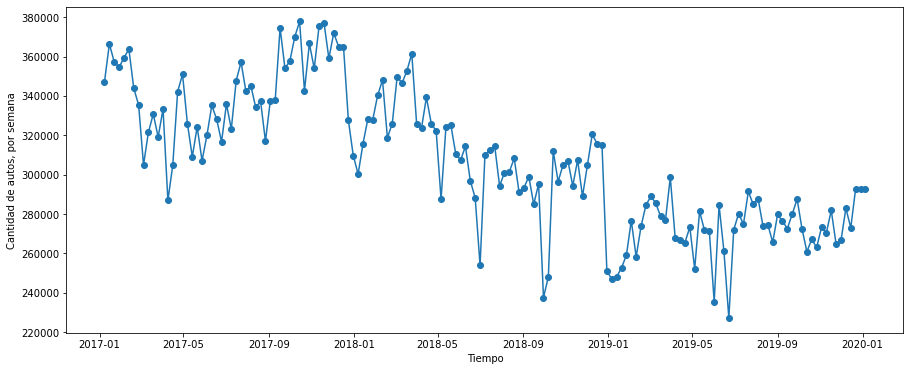

In [9]:
plt.figure(figsize = (15,6))
plt.plot(semanal.index, semanal.cantidad_pasos)
plt.scatter(semanal.index, semanal.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por semana')
plt.show()

Benchmarks and advanced models, to compare results

### First, One - Step Prediction

In [9]:
senial = semanal.cantidad_pasos
look_back = 16
N = senial.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
for i in range(X.shape[0]):
#     X[i,:] = senial.values.iloc[i:i+look_back]
#     y[i] = senial.values.iloc[i+look_back]
    X[i,:] = senial.iloc[i:i+look_back]
    y[i] = senial.iloc[i+look_back]
N_train =  156 -12 - look_back  
N_test = 12 
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs = 1).fit(X_train,y_train)
y_pred = rf.predict(X)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
MSE = mean_squared_error(y_train, y_train_pred)
print('Train Error:',np.sqrt(MSE))

MSE = mean_squared_error(y_test, y_test_pred)
print('Test Error:',np.sqrt(MSE))

(128, 16) (128,)
(12, 16) (12,)
Train Error: 7609.63613081749
Test Error: 11446.278488647165


### When we optimized Random Forest, the error in Test was: 11097.178002682027

**Benchmark**

In [10]:
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]
MSE = mean_squared_error(y_test, y[-1 + N_train:N_train+N_test - 1])
print(np.sqrt(MSE))


11163.346780125274


Then, implement:
    
 ### XG-BOOST = 
    ONE-STEP PREDICTION
    Error in Train: 3290.4280231550815
    Error in Test: 12512.11284595324
        
    MULTI-STEP PREDICTION
    
        
   ### Error in Test: 11829.264482467257

### Finally, with **Prophet** TEST error was 16868.665195392565

However, using these models to predict the year 2020 (first quarter) we got the following results:
    
    -Random Forest 
                Error in Train: 8010.817434853192
                Error in Test: 25759.67927843722
                
    -XG-Boost 
                Error in Train: 4828.842612077854
                Error in Test: 27495.28752815012
                    
    -Prophet 
                Error in Test: 14559.17692315534

In summary, the best model to predict 2019 was Random Forest, but when predicting 2020, Prophet was more efficient.

Next we will seek to improve these results and test Machine Learning models not used so far.

In [11]:
#A seasonal ARIMA model or SARIMA
import itertools

d = range(1, 2) #We differentiate it once to de-trend it
p = q = range(10, 17) #Establish a reasonable range that considers the look back
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (10, 1, 11) x (10, 1, 11, 12)
SARIMAX: (10, 1, 11) x (10, 1, 12, 12)
SARIMAX: (10, 1, 12) x (10, 1, 13, 12)
SARIMAX: (10, 1, 12) x (10, 1, 14, 12)


In [12]:
import statsmodels.api as sm
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(semanal,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

C:\Users\Usuario\miniconda3\envs\datascience\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Usuario\miniconda3\envs\datascience\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(10, 1, 10)x(10, 1, 10, 12)12 - AIC:368.3723486714564
ARIMA(10, 1, 10)x(10, 1, 11, 12)12 - AIC:106.02785933030431
ARIMA(10, 1, 10)x(10, 1, 12, 12)12 - AIC:86.0
ARIMA(10, 1, 10)x(10, 1, 13, 12)12 - AIC:88.0
ARIMA(10, 1, 10)x(10, 1, 14, 12)12 - AIC:90.0
ARIMA(10, 1, 10)x(10, 1, 15, 12)12 - AIC:92.0
ARIMA(10, 1, 10)x(10, 1, 16, 12)12 - AIC:94.0
ARIMA(10, 1, 10)x(11, 1, 10, 12)12 - AIC:128.0559266407413
ARIMA(10, 1, 10)x(11, 1, 11, 12)12 - AIC:108.02782479220345
ARIMA(10, 1, 10)x(11, 1, 12, 12)12 - AIC:88.0
ARIMA(10, 1, 10)x(11, 1, 13, 12)12 - AIC:90.0
ARIMA(10, 1, 10)x(11, 1, 14, 12)12 - AIC:92.0
ARIMA(10, 1, 10)x(11, 1, 15, 12)12 - AIC:94.0
ARIMA(10, 1, 10)x(11, 1, 16, 12)12 - AIC:96.0
ARIMA(10, 1, 10)x(12, 1, 10, 12)12 - AIC:86.0
ARIMA(10, 1, 10)x(12, 1, 11, 12)12 - AIC:88.0
ARIMA(10, 1, 10)x(12, 1, 12, 12)12 - AIC:90.0
ARIMA(10, 1, 10)x(12, 1, 13, 12)12 - AIC:92.0
ARIMA(10, 1, 10)x(12, 1, 14, 12)12 - AIC:94.0
ARIMA(10, 1, 10)x(12, 1, 15, 12)12 - AIC:96.0
ARIMA(10, 1, 10)x(12, 1, 1

C:\Users\Usuario\miniconda3\envs\datascience\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(10, 1, 11)x(10, 1, 10, 12)12 - AIC:348.3155983703208


C:\Users\Usuario\miniconda3\envs\datascience\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1220: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /


ARIMA(10, 1, 11)x(10, 1, 11, 12)12 - AIC:86.0
ARIMA(10, 1, 11)x(10, 1, 12, 12)12 - AIC:88.0
ARIMA(10, 1, 11)x(10, 1, 13, 12)12 - AIC:90.0
ARIMA(10, 1, 11)x(10, 1, 14, 12)12 - AIC:92.0
ARIMA(10, 1, 11)x(10, 1, 15, 12)12 - AIC:94.0
ARIMA(10, 1, 11)x(10, 1, 16, 12)12 - AIC:96.0
ARIMA(10, 1, 11)x(11, 1, 10, 12)12 - AIC:130.05209475486436
ARIMA(10, 1, 11)x(11, 1, 11, 12)12 - AIC:88.0
ARIMA(10, 1, 11)x(11, 1, 12, 12)12 - AIC:90.0
ARIMA(10, 1, 11)x(11, 1, 13, 12)12 - AIC:92.0
ARIMA(10, 1, 11)x(11, 1, 14, 12)12 - AIC:94.0
ARIMA(10, 1, 11)x(11, 1, 15, 12)12 - AIC:96.0
ARIMA(10, 1, 11)x(11, 1, 16, 12)12 - AIC:98.0
ARIMA(10, 1, 11)x(12, 1, 10, 12)12 - AIC:88.0
ARIMA(10, 1, 11)x(12, 1, 11, 12)12 - AIC:90.0
ARIMA(10, 1, 11)x(12, 1, 12, 12)12 - AIC:92.0
ARIMA(10, 1, 11)x(12, 1, 13, 12)12 - AIC:94.0
ARIMA(10, 1, 11)x(12, 1, 14, 12)12 - AIC:96.0
ARIMA(10, 1, 11)x(12, 1, 15, 12)12 - AIC:98.0
ARIMA(10, 1, 11)x(12, 1, 16, 12)12 - AIC:100.0
ARIMA(10, 1, 11)x(13, 1, 10, 12)12 - AIC:90.0
ARIMA(10, 1, 11)x(1

C:\Users\Usuario\miniconda3\envs\datascience\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(11, 1, 10)x(10, 1, 10, 12)12 - AIC:370.47085469631236
ARIMA(11, 1, 10)x(10, 1, 11, 12)12 - AIC:108.03290937691332
ARIMA(11, 1, 10)x(10, 1, 12, 12)12 - AIC:88.0
ARIMA(11, 1, 10)x(10, 1, 13, 12)12 - AIC:90.0
ARIMA(11, 1, 10)x(10, 1, 14, 12)12 - AIC:92.0
ARIMA(11, 1, 10)x(10, 1, 15, 12)12 - AIC:94.0
ARIMA(11, 1, 10)x(10, 1, 16, 12)12 - AIC:96.0
ARIMA(11, 1, 10)x(11, 1, 10, 12)12 - AIC:108.03281008589802
ARIMA(11, 1, 10)x(11, 1, 11, 12)12 - AIC:110.03269463287486
ARIMA(11, 1, 10)x(11, 1, 12, 12)12 - AIC:90.0
ARIMA(11, 1, 10)x(11, 1, 13, 12)12 - AIC:92.0
ARIMA(11, 1, 10)x(11, 1, 14, 12)12 - AIC:94.0
ARIMA(11, 1, 10)x(11, 1, 15, 12)12 - AIC:96.0
ARIMA(11, 1, 10)x(11, 1, 16, 12)12 - AIC:98.0
ARIMA(11, 1, 10)x(12, 1, 10, 12)12 - AIC:88.0
ARIMA(11, 1, 10)x(12, 1, 11, 12)12 - AIC:90.0
ARIMA(11, 1, 10)x(12, 1, 12, 12)12 - AIC:92.0
ARIMA(11, 1, 10)x(12, 1, 13, 12)12 - AIC:94.0
ARIMA(11, 1, 10)x(12, 1, 14, 12)12 - AIC:96.0
ARIMA(11, 1, 10)x(12, 1, 15, 12)12 - AIC:98.0
ARIMA(11, 1, 10)x(12, 1,

C:\Users\Usuario\miniconda3\envs\datascience\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(11, 1, 11)x(10, 1, 10, 12)12 - AIC:350.3220920335955
ARIMA(11, 1, 11)x(10, 1, 11, 12)12 - AIC:88.0
ARIMA(11, 1, 11)x(10, 1, 12, 12)12 - AIC:90.0
ARIMA(11, 1, 11)x(10, 1, 13, 12)12 - AIC:92.0
ARIMA(11, 1, 11)x(10, 1, 14, 12)12 - AIC:94.0
ARIMA(11, 1, 11)x(10, 1, 15, 12)12 - AIC:96.0
ARIMA(11, 1, 11)x(10, 1, 16, 12)12 - AIC:98.0
ARIMA(11, 1, 11)x(11, 1, 10, 12)12 - AIC:110.02674728393124
ARIMA(11, 1, 11)x(11, 1, 11, 12)12 - AIC:90.0
ARIMA(11, 1, 11)x(11, 1, 12, 12)12 - AIC:92.0
ARIMA(11, 1, 11)x(11, 1, 13, 12)12 - AIC:94.0
ARIMA(11, 1, 11)x(11, 1, 14, 12)12 - AIC:96.0
ARIMA(11, 1, 11)x(11, 1, 15, 12)12 - AIC:98.0
ARIMA(11, 1, 11)x(11, 1, 16, 12)12 - AIC:100.0
ARIMA(11, 1, 11)x(12, 1, 10, 12)12 - AIC:90.0
ARIMA(11, 1, 11)x(12, 1, 11, 12)12 - AIC:92.0
ARIMA(11, 1, 11)x(12, 1, 12, 12)12 - AIC:94.0
ARIMA(11, 1, 11)x(12, 1, 13, 12)12 - AIC:96.0
ARIMA(11, 1, 11)x(12, 1, 14, 12)12 - AIC:98.0
ARIMA(11, 1, 11)x(12, 1, 15, 12)12 - AIC:100.0
ARIMA(11, 1, 11)x(12, 1, 16, 12)12 - AIC:102.0
ARIM

In [13]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(semanal,
                                order=(10, 1, 11),
                                seasonal_order=(10, 1, 11, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

C:\Users\Usuario\miniconda3\envs\datascience\lib\site-packages\statsmodels\tools\eval_measures.py:406: RuntimeWarning: divide by zero encountered in log
  return -2.0 * llf + np.log(nobs) * df_modelwc
C:\Users\Usuario\miniconda3\envs\datascience\lib\site-packages\statsmodels\tools\eval_measures.py:431: RuntimeWarning: divide by zero encountered in log
  return -2.0 * llf + 2 * np.log(np.log(nobs)) * df_modelwc
C:\Users\Usuario\miniconda3\envs\datascience\lib\site-packages\statsmodels\tools\eval_measures.py:431: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + 2 * np.log(np.log(nobs)) * df_modelwc
C:\Users\Usuario\miniconda3\envs\datascience\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3103: UserWarning: Later subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  warnings.warn('Later subset of data for variable %d'
C:\Users\Usuario\miniconda3\envs\datascience\lib\site-packages\statsmodels\tsa\stattools.py:469

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2788        nan        nan        nan         nan         nan
ar.L2         -0.2216        nan        nan        nan         nan         nan
ar.L3         -0.0377        nan        nan        nan         nan         nan
ar.L4         -0.1958        nan        nan        nan         nan         nan
ar.L5         -0.0658        nan        nan        nan         nan         nan
ar.L6         -0.0920        nan        nan        nan         nan         nan
ar.L7         -0.2577        nan        nan        nan         nan         nan
ar.L8          0.1949        nan        nan        nan         nan         nan
ar.L9         -0.0771        nan        nan        nan         nan         nan
ar.L10         0.1160        nan        nan        nan         nan         nan
ma.L1         -0.1072        nan        nan        n

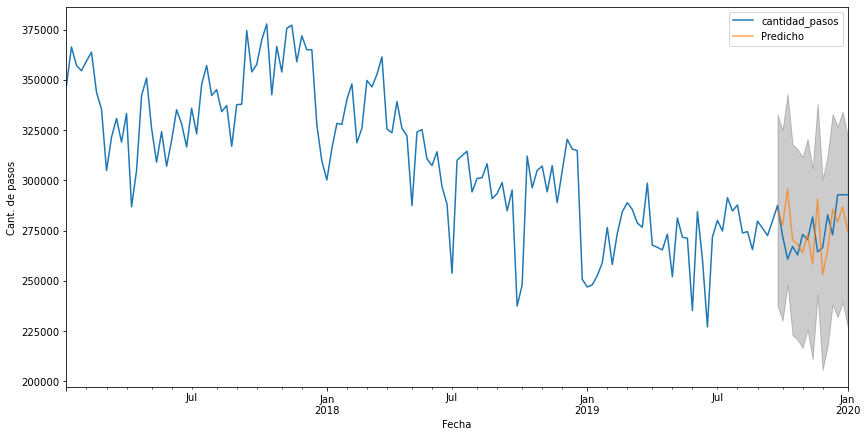

In [14]:
pred = results.get_prediction(start=pd.to_datetime('2019-09-29'), dynamic=False)
pred_ci = pred.conf_int()

ax = semanal['2017':].plot(label='observado')
pred.predicted_mean.plot(ax=ax, label='Predicho', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Fecha')
ax.set_ylabel('Cant. de pasos')
plt.legend()

plt.show()

In [15]:
from sklearn.metrics import mean_squared_error

y_forecasted = pred.predicted_mean
y_truth = semanal['2019-09-29':]


rmse_sarima = np.sqrt(mean_squared_error(y_forecasted, y_truth))
print(f'RMSE SARIMAX One-Step: {rmse_sarima}')


RMSE SARIMAX One-Step: 15939.888438918719


The result with SARIMA isn't good enough. So, we'll try with neural networks

In [90]:
#Neural Networks
from sklearn.preprocessing import MinMaxScaler
#We will use an LSTM recurrent neural network to make the prediction
#We create the dataset, we normalize it, we divide the train and test and finally we convert the array of values into a matrix dataset
dataset = semanal.cantidad_pasos.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(128)
test_size = 12
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [91]:
#Convert the array of values to a matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [92]:
# reshape X=t y Y=t+1
look_back = 16
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [93]:
X_train.shape

(111, 16)

In [94]:
Y_train.shape

(111,)

In [95]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [11]:
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [96]:
model = Sequential()
model.add(LSTM(36, input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=10, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Training Phase
model.summary()

Train on 111 samples, validate on 12 samples
Epoch 1/20
111/111 [==============================] - 1s 8ms/step - loss: 0.4983 - val_loss: 0.0802
Epoch 2/20
111/111 [==============================] - 0s 532us/step - loss: 0.2416 - val_loss: 0.0297
Epoch 3/20
111/111 [==============================] - 0s 460us/step - loss: 0.1000 - val_loss: 0.0082
Epoch 4/20
111/111 [==============================] - 0s 514us/step - loss: 0.0375 - val_loss: 0.0052
Epoch 5/20
111/111 [==============================] - 0s 478us/step - loss: 0.0239 - val_loss: 0.0068
Epoch 6/20
111/111 [==============================] - 0s 496us/step - loss: 0.0232 - val_loss: 0.0066
Epoch 7/20
111/111 [==============================] - 0s 460us/step - loss: 0.0219 - val_loss: 0.0058
Epoch 8/20
111/111 [==============================] - 0s 496us/step - loss: 0.0216 - val_loss: 0.0054
Epoch 9/20
111/111 [==============================] - 0s 469us/step - loss: 0.0217 - val_loss: 0.0054
Epoch 10/20
111/111 [==================

In [97]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
#Predict
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 16928.038474849825
Train Root Mean Squared Error: 21646.45334996724
Test Mean Absolute Error: 9810.309333724615
Test Root Mean Squared Error: 10871.668560260518


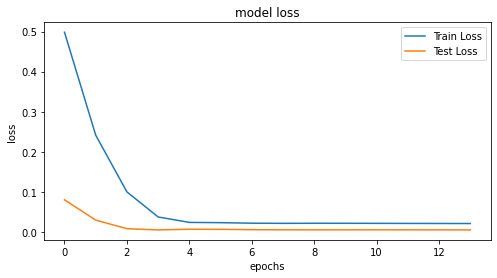

In [98]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [47]:
import matplotlib.ticker as tkr
import matplotlib.pyplot as plt
import seaborn as sns


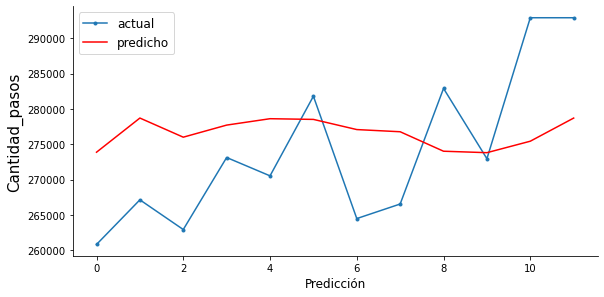

In [99]:
aa=[x for x in range(12)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:100], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:100], 'r', label="predicho")
#plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Cantidad_pasos', size=15)
plt.xlabel('Predicción', size=12)
plt.legend(fontsize=12)
plt.show();

#### Prediction of the last 12 weeks of 2019, that is last quarter... So far, the LSTM network is the one that gives us the best result, with an error of 10871.668560260518

In [100]:
#... See what happens when we try to predict 2020 (1st Quarter)
data_2020 = pd.read_csv('flujo-vehicular-2020.csv', sep =',')
mask = np.logical_and(data_2020.estacion=='ILLIA', data_2020.forma_pago == 'Efectivo')
data_2020 = data_2020[mask]
data_2020.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

data_2020['fecha2'] = pd.to_datetime(data_2020.fecha) + pd.to_timedelta(data_2020.hora_fin, unit = 'h')

data_2020.drop(columns=['fecha','hora_fin'], inplace = True)

data_2020.head()

,mes,dia,dia_fecha,tipo_vehiculo,observacion,sentido,cantidad_pasos,fecha2
52,enero,Miércoles,1.0,Auto,Efectivo,Centro,326.0,2020-01-01 01:00:00
53,enero,Miércoles,1.0,Auto,Efectivo,Provincia,319.0,2020-01-01 01:00:00
134,enero,Miércoles,1.0,Auto,Efectivo,Centro,199.0,2020-01-01 02:00:00
135,enero,Miércoles,1.0,Auto,Efectivo,Provincia,180.0,2020-01-01 02:00:00
202,enero,Miércoles,1.0,Auto,Efectivo,Centro,114.0,2020-01-01 03:00:00


In [101]:
data_2020.rename(columns = {'fecha2':'fecha'}, inplace = True)
data_2020.sort_values('fecha', inplace = True)
data_2020.reset_index(drop=True, inplace = True)

#Resample
semanal_2020 = data_2020.resample('W', on = 'fecha').sum()
print(semanal_2020.shape)
semanal_2020.head()

(53, 2)


,dia_fecha,cantidad_pasos
fecha,,
2020-01-05,3119.0,150623.0
2020-01-12,12928.0,243359.0
2020-01-19,23816.0,246818.0
2020-01-26,34297.0,241192.0
2020-02-02,32671.0,253335.0


In [102]:
semanal_test = semanal_2020[semanal_2020.index < "2020-03-29"]
semanal_trash = semanal_2020[semanal_2020.index >= "2020-03-29"] #1st quarter

del(semanal_test['dia_fecha'])
#Concat the datasets
semanal_concat = semanal[semanal.index< "2020-01-01"]

semanal_concatenado = pd.concat([semanal_concat, semanal_test])
semanal_concatenado.cantidad_pasos[semanal_concatenado.cantidad_pasos <160000] = np.nan #utilizamos numpy

In [103]:
print(semanal_concatenado.isna().sum())
semanal_concatenado = semanal_concatenado.interpolate()
print(semanal_concatenado.isna().sum())

cantidad_pasos    2
dtype: int64
cantidad_pasos    0
dtype: int64


In [16]:
#Train the neural network 

In [142]:
dataset = semanal_concatenado.cantidad_pasos.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(140)
test_size = 13
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

ERROR! Session/line number was not unique in database. History logging moved to new session 1020


In [143]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [144]:
look_back = 16
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [145]:
X_train.shape

(123, 16)

In [146]:
Y_train.shape

(123,)

In [147]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [148]:
model = Sequential()
model.add(LSTM(48, input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=30, batch_size=5, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Training Phase
model.summary()

Train on 123 samples, validate on 11 samples
Epoch 1/30
123/123 [==============================] - 1s 8ms/step - loss: 0.1052 - val_loss: 0.0317
Epoch 2/30
123/123 [==============================] - 0s 871us/step - loss: 0.0251 - val_loss: 0.0201
Epoch 3/30
123/123 [==============================] - 0s 968us/step - loss: 0.0233 - val_loss: 0.0218
Epoch 4/30
123/123 [==============================] - 0s 952us/step - loss: 0.0223 - val_loss: 0.0202
Epoch 5/30
123/123 [==============================] - 0s 919us/step - loss: 0.0222 - val_loss: 0.0198
Epoch 6/30
123/123 [==============================] - 0s 879us/step - loss: 0.0217 - val_loss: 0.0189
Epoch 7/30
123/123 [==============================] - 0s 936us/step - loss: 0.0214 - val_loss: 0.0184
Epoch 8/30
123/123 [==============================] - 0s 944us/step - loss: 0.0210 - val_loss: 0.0178
Epoch 9/30
123/123 [==============================] - 0s 895us/step - loss: 0.0207 - val_loss: 0.0173
Epoch 10/30
123/123 [==================

In [149]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 15366.387008174575
Train Root Mean Squared Error: 19051.138678780226
Test Mean Absolute Error: 13550.071797638067
Test Root Mean Squared Error: 17111.933882807883


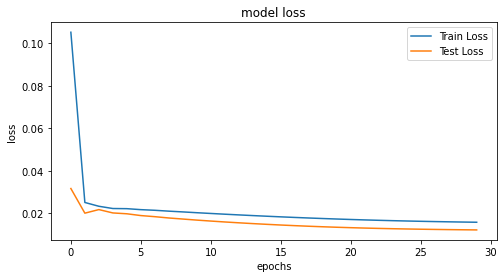

In [150]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

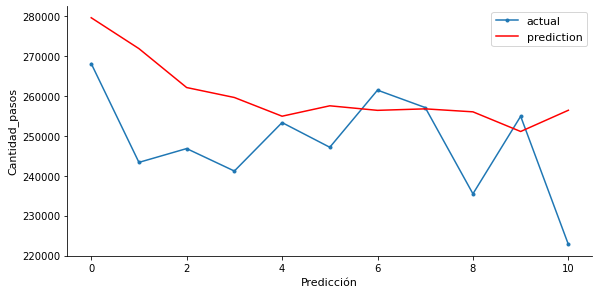

In [151]:
aa=[x for x in range(11)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
#plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Cantidad_pasos', size=11)
plt.xlabel('Predicción', size=11)
plt.legend(fontsize=11)
plt.show();

At the moment, the LSTM network manages to be better than the Random Forest and XG Boost models for predicting 2020, however, Prophet is still superior...

On the other hand, it is the model that best predicts the last quarter of 2019, beating Random Forest, which was our best model in the previous project. In short, we would choose this new model. We see the result reflected in the following graphs:

In [17]:
rmse_RandomForest = 11097.178002682027
rmse_XGBOOST = 11829.264482467257
rmse_Prophet = 16868.665195392565
rmse_SARIMA = 15939.888438918719
rmse_LSTM = 10871.668560260518


list_scores = [rmse_RandomForest, rmse_XGBOOST, rmse_Prophet, rmse_SARIMA, rmse_LSTM]
list_regressors = ['RF','XGB', 'Prophet','Sarima', 'LSTM']


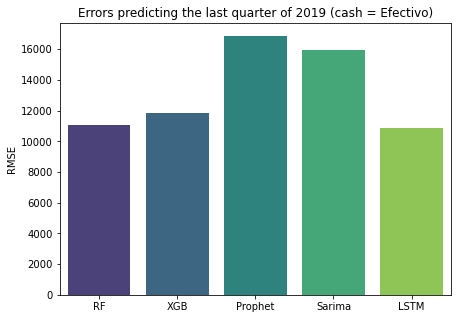

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(7,5)
sns.barplot(x=list_regressors, y=list_scores, ax=ax, palette = 'viridis')
plt.ylabel('RMSE')
plt.title('Errors predicting the last quarter of 2019 (cash = Efectivo)')
plt.show()


In [21]:
rmse_RandomForest = 25759.67927843722
rmse_XGBOOST = 27495.28752815012
rmse_Prophet = 14559.17692315534
rmse_LSTM = 17111.933882807883
    


list_scores = [rmse_RandomForest, rmse_XGBOOST, rmse_Prophet, rmse_LSTM]
list_regressors = ['RF','XGB', 'Prophet', 'LSTM']


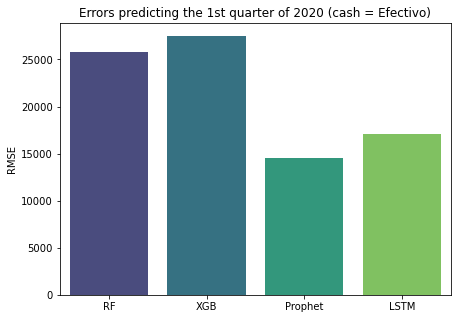

In [22]:
fig, ax = plt.subplots()
fig.set_size_inches(7,5)
sns.barplot(x=list_regressors, y=list_scores, ax=ax, palette = 'viridis')
plt.ylabel('RMSE')
plt.title('Errors predicting the 1st quarter of 2020 (cash = Efectivo)')
plt.show()

As we can see, both for the prediction of the last quarter of 2019, and for the first quarter of 2020, LSTM has "low" error compared to the rest, for this reason we chose this model over the other implemented models. Likewise, it was a model that quickly grasped the nature of the data.

### On the other hand...

Now, what we are looking for is to add the different types of payment to the dataset to see what happens with the series, how it behaves and what happens with the prediction... We will then try to predict the last quarter of 2019, using all the means of payment, with the Random Forest and Neural Networks models, since they were the two that gave us the best results to predict that quarter.

In [3]:
data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')

dataset_b = pd.concat([data_2019, data_2018, data_2017])

mask = np.logical_and(dataset_b.estacion=='Illia', dataset_b.forma_pago != 'Otros')
dataset_b = dataset_b[mask]

dataset_b.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset_b.head()

,fecha,hora_fin,dia,sentido,tipo_vehiculo,cantidad_pasos
19,2019-01-01,1,Martes,Centro,Liviano,146
20,2019-01-01,1,Martes,Centro,Liviano,59
21,2019-01-01,1,Martes,Centro,Pesado,1
22,2019-01-01,1,Martes,Provincia,Liviano,147
23,2019-01-01,1,Martes,Provincia,Liviano,106


In [4]:
dataset_b['fecha2'] = pd.to_datetime(dataset_b.fecha) + pd.to_timedelta(dataset_b.hora_fin, unit = 'h')

dataset_b.drop(columns=['fecha','hora_fin'], inplace = True)

dataset_b.rename(columns = {'fecha2':'fecha'}, inplace = True) 

dataset_b.sort_values('fecha', inplace = True)
dataset_b.reset_index(drop=True, inplace = True)
dataset_b

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Domingo,Centro,Liviano,459,2017-01-01 00:00:00
1,Domingo,Provincia,Pesado,3,2017-01-01 00:00:00
2,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
3,Domingo,Provincia,Pesado,7,2017-01-01 00:00:00
4,Domingo,Provincia,Pesado,6,2017-01-01 00:00:00
...,...,...,...,...,...
752547,Martes,Centro,Liviano,122,2019-12-31 23:00:00
752548,Martes,Centro,Liviano,3,2019-12-31 23:00:00
752549,Martes,Centro,Liviano,4,2019-12-31 23:00:00
752550,Martes,Centro,Liviano,1,2019-12-31 23:00:00


In [5]:
#Resample
semanal_b = dataset_b.resample('W', on = 'fecha').sum()
print(semanal_b.shape)
semanal_b.head()

(158, 1)


,cantidad_pasos
fecha,
2017-01-01,45478
2017-01-08,585700
2017-01-15,613675
2017-01-22,599307
2017-01-29,598163


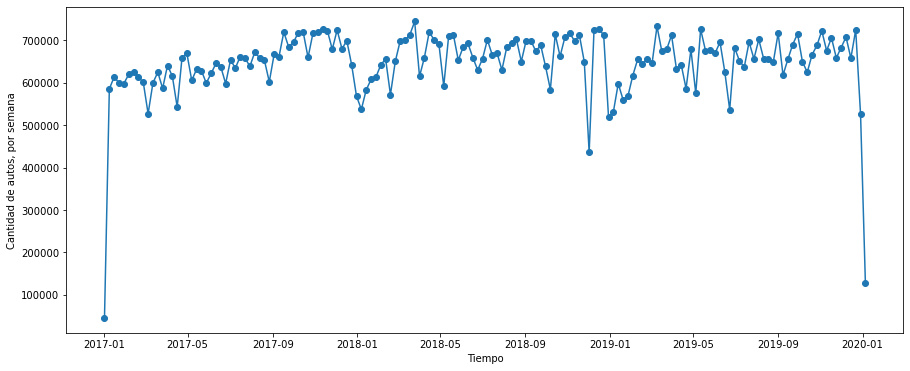

In [155]:
plt.figure(figsize = (15,6))
plt.plot(semanal_b.index, semanal_b.cantidad_pasos)
plt.scatter(semanal_b.index, semanal_b.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por semana')
plt.show()

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(semanal_b.cantidad_pasos, model='additive')
#result.plot()
#pyplot.show()

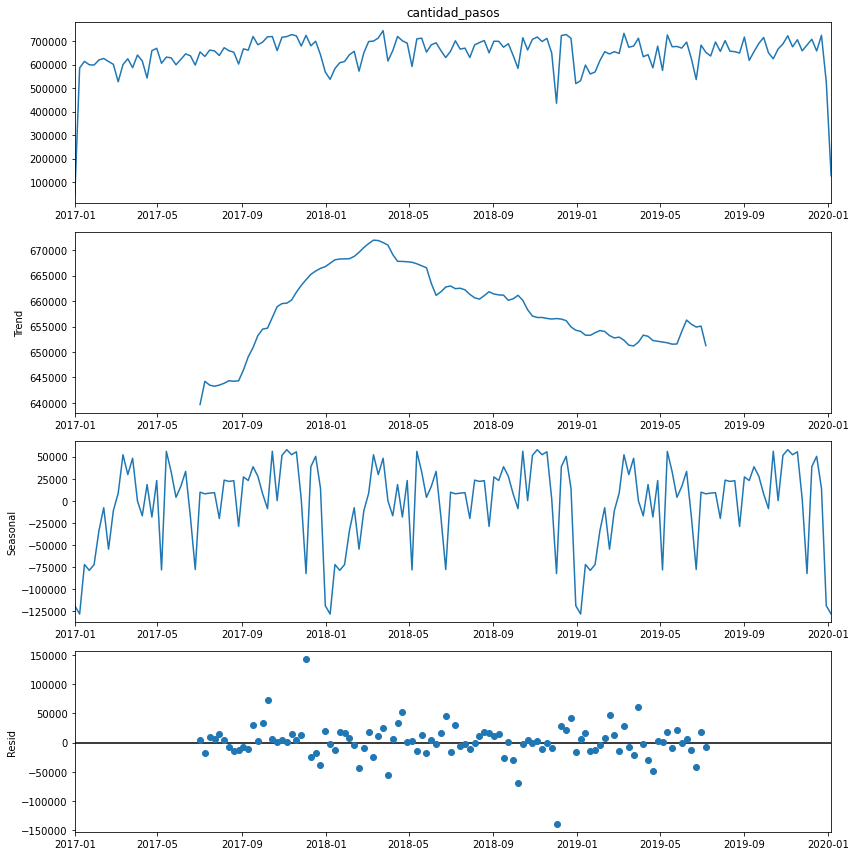

In [9]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [12,12]
result.plot()
plt.show()

In [23]:
#OBS: Different trend 

In [10]:
from statsmodels.tsa.stattools import acf

nlags =  52*2 #Number of lags to return autocorrelation for.
autocorr = acf(semanal_b.cantidad_pasos, nlags = nlags)

C:\Users\Usuario\miniconda3\envs\datascience\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


Text(0.5, 0, 'lag')

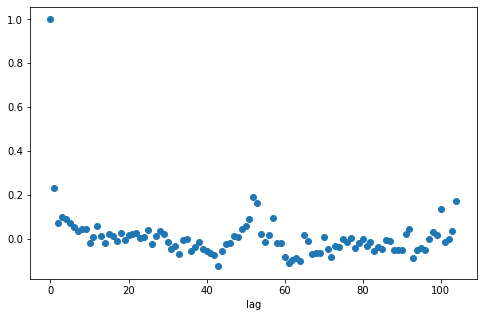

In [11]:
plt.figure(figsize = (8,5))
plt.scatter(np.arange(nlags+1), autocorr)
plt.xlabel('lag')

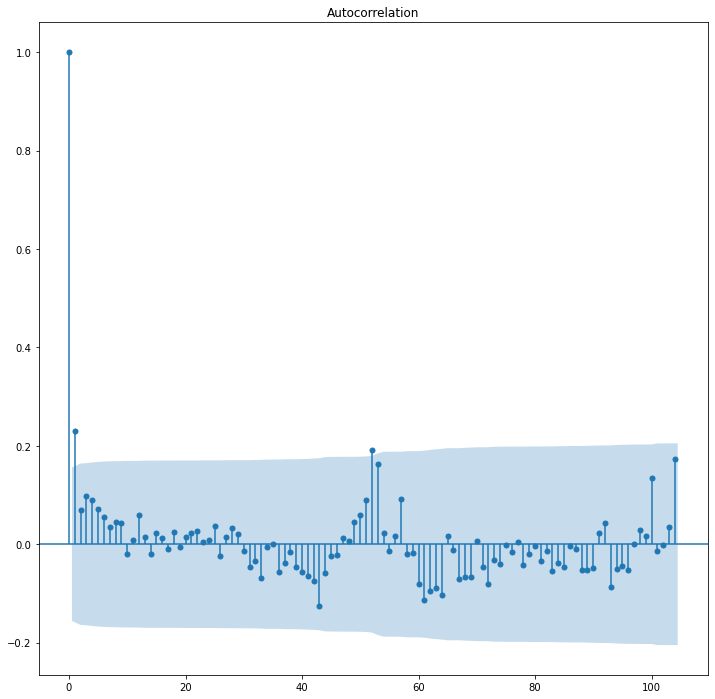

In [12]:
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(semanal_b, lags=52*2)
pyplot.show()

In [24]:
#Obs, we found an important relationship with week 1 and 2, and then with week 53 (that is, just one year ago)

In [6]:
semanal_b.cantidad_pasos[semanal_b.cantidad_pasos < 525808] = np.nan #utilizamos numpy

In [7]:
print(semanal_b.isna().sum())
semanal_b = semanal_b.interpolate()
print(semanal_b.isna().sum())

cantidad_pasos    5
dtype: int64
cantidad_pasos    1
dtype: int64


In [8]:
semanal_b.dropna(inplace=True)

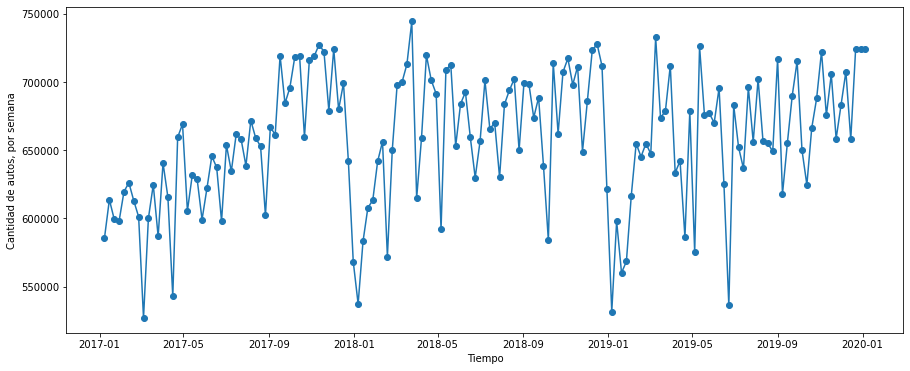

In [9]:
plt.figure(figsize = (15,6))
plt.plot(semanal_b.index, semanal_b.cantidad_pasos)
plt.scatter(semanal_b.index, semanal_b.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por semana')
plt.show()

In [160]:
semanal_b.describe()

,cantidad_pasos
count,157.000000
mean,658087.754777
std,48240.529818
min,526914.000000
25%,626109.000000
50%,659147.000000
75%,698089.000000
max,744460.000000


Observation, we went from having an average of approximately 300,000 weekly steps, to having an average error of 658087.754777 so having this in consideration, it isn't really big

In [98]:
#Neural Network
from sklearn.preprocessing import MinMaxScaler
dataset_b = semanal_b.cantidad_pasos.values #numpy.ndarray
dataset_b = dataset_b.astype('float32')
dataset_b = np.reshape(dataset_b, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_b = scaler.fit_transform(dataset_b)
train_size = int(91)
test_size = 12
train, test = dataset_b[0:train_size,:], dataset_b[train_size:len(dataset_b),:]

In [99]:
def create_dataset(dataset_b, look_back=1):
    X, Y = [], []
    for i in range(len(dataset_b)-look_back-1):
        a = dataset_b[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset_b[i + look_back, 0])
    return np.array(X), np.array(Y)

In [100]:
look_back = 53
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [101]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [102]:
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)

model = Sequential()
model.add(LSTM(48, input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(Dense(48))
#model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


history = model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Training Phase
model.summary()

Train on 37 samples, validate on 12 samples
Epoch 1/20
37/37 [==============================] - 1s 28ms/step - loss: 0.4614 - val_loss: 0.3698
Epoch 2/20
37/37 [==============================] - 0s 406us/step - loss: 0.2812 - val_loss: 0.2108
Epoch 3/20
37/37 [==============================] - 0s 433us/step - loss: 0.1510 - val_loss: 0.1015
Epoch 4/20
37/37 [==============================] - 0s 460us/step - loss: 0.0704 - val_loss: 0.0399
Epoch 5/20
37/37 [==============================] - 0s 460us/step - loss: 0.0359 - val_loss: 0.0178
Epoch 6/20
37/37 [==============================] - 0s 460us/step - loss: 0.0366 - val_loss: 0.0195
Epoch 7/20
37/37 [==============================] - 0s 460us/step - loss: 0.0538 - val_loss: 0.0264
Epoch 8/20
37/37 [==============================] - 0s 541us/step - loss: 0.0678 - val_loss: 0.0280
Epoch 9/20
37/37 [==============================] - 0s 406us/step - loss: 0.0696 - val_loss: 0.0240
Epoch 10/20
37/37 [==============================] - 0s 5

In [103]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
#Predict
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 32258.828690421546
Train Root Mean Squared Error: 39055.44888543581
Test Mean Absolute Error: 32916.35358387908
Test Root Mean Squared Error: 39200.48622355709


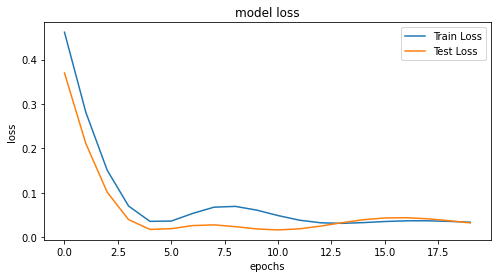

In [104]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

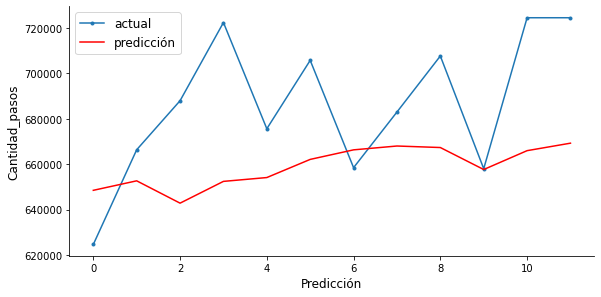

In [105]:
import seaborn as sns
aa=[x for x in range(12)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="predicción")
#plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Cantidad_pasos', size=12)
plt.xlabel('Predicción', size=12)
plt.legend(fontsize=12)
plt.show();

We predict with LSTM the last quarter of 2019, including all payment types, and we achieve an error of 39200.48622355709, that is, 6%

In [25]:
#Random Forest

In [45]:
senial = semanal_b.cantidad_pasos
senial.head()

fecha
2017-01-08    585700.0
2017-01-15    613675.0
2017-01-22    599307.0
2017-01-29    598163.0
2017-02-05    619701.0
Freq: W-SUN, Name: cantidad_pasos, dtype: float64

In [65]:
look_back = 53
N = senial.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

for i in range(X.shape[0]):
#     X[i,:] = senial.values.iloc[i:i+look_back]
#     y[i] = senial.values.iloc[i+look_back]
    X[i,:] = senial.iloc[i:i+look_back]
    y[i] = senial.iloc[i+look_back]
    
N_train =  156 -12 - look_back
N_test = 12 
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(103, 53) (103,)
(91, 53) (91,)
(12, 53) (12,)


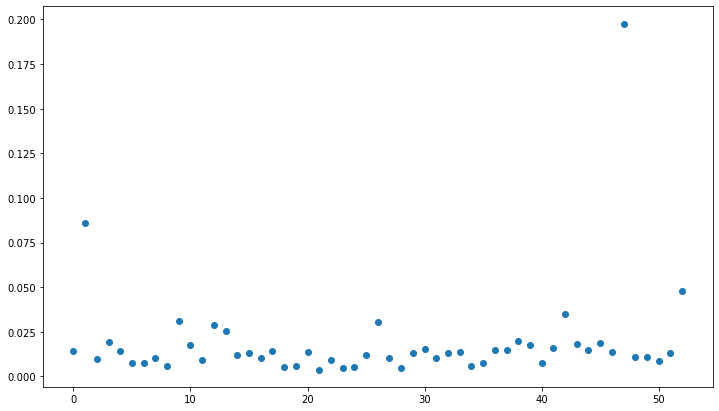

In [66]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs = 1).fit(X_train,y_train)
plt.figure(figsize = (12,7))
plt.scatter(np.arange(rf.feature_importances_.size),rf.feature_importances_)
# for x in np.arange(3)*52:
#     plt.axvline(x, linestyle ='--', color= 'r')
plt.show()

In [67]:
y_pred = rf.predict(X)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

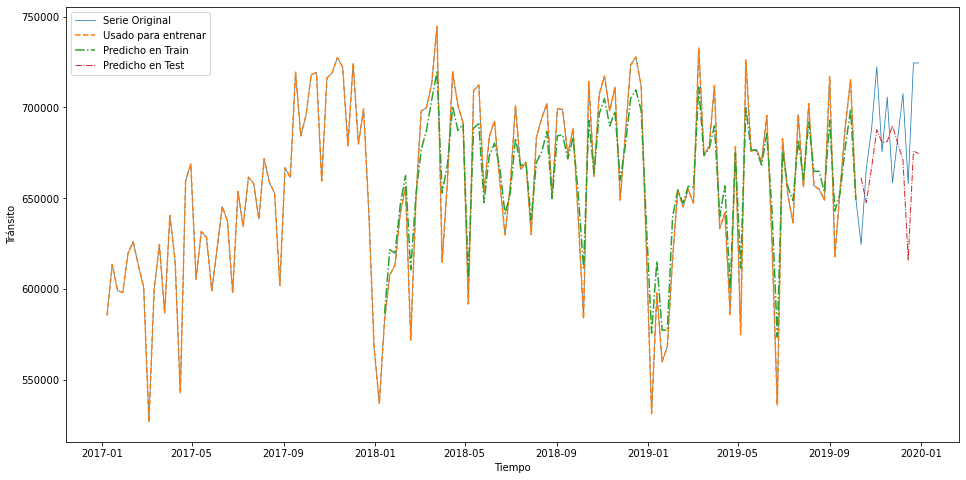

In [68]:
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 1, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Tránsito')
plt.show()

In [69]:
MSE = mean_squared_error(y_train, y_train_pred)
print('Error in Train:',np.sqrt(MSE))

MSE = mean_squared_error(y_test, y_test_pred)
print('Error in Test:',np.sqrt(MSE))

Error en Train: 15704.408677956091
Error en Test: 32784.233337238125


We will try a benchmark predicting with the value of the previous week

In [70]:
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]

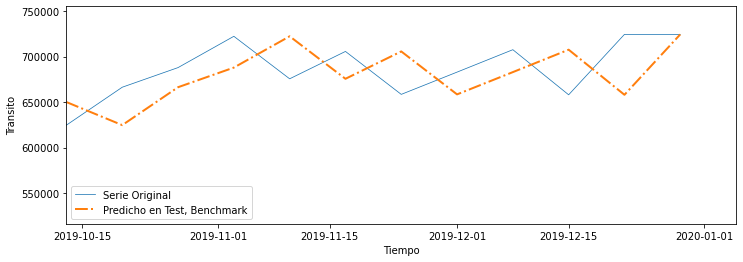

In [71]:
plt.figure(figsize=(12,4))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred_benchmark,'-.', lw = 2, label = 'Predicho en Test, Benchmark')
plt.xlim(senial.index[N_train+look_back], senial.index[length_total])
plt.xlabel('Tiempo')
plt.ylabel('Transito')

plt.legend()
plt.show()

In [57]:
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]
MSE = mean_squared_error(y_test, y[-1 + N_train:N_train+N_test - 1])
print(np.sqrt(MSE))

38138.314152786916


In conclusion, using all payment methods, the model that gives us the best prediction is Random Forest (5% error)

With Random Forest, predicting the last quarter of 2019 with all payment types, we achieve an error of 5%, while predicting for the cash payment type we achieve an error of approximately 3.5%. This means that we obtained a smaller error when predicting only the type of CASH payment.

On the other hand, regarding the neural networks, predicting the last quarter of 2019 with all payment types, we achieve an error of approximately 6%, while predicting for the cash payment type we achieve an error of approximately 3.5%. This again reinforces our idea that we get the least error predicting the CASH payment type.

It should be noted that although the trends are different and the amount of data in both datasets is different, predicting for a particular type of payment (as in this case it is cash) we achieve the most accurate prediction. This leads us to the conclusion that it is preferable to divide the different types of payment into different datasets.

Likewise, the objective of the notebook was to predict the last quarter of 2019, achieving a better result, which was achieved using LSTM neural networks.